#   Q18 Machine Learning Rolling Basis

In this example we predict whether the price will rise or fall by using supervised learning (Bayesian Ridge Regression). This template represents a starting point for developing a system which can take part to the **Q18 NASDAQ-100 Stock Long-Short contest**.

It consists of two parts.

* In the **first part** we just perform a global training of the time series using all time series data. We disregard the sequential aspect of the data and use also future data to train past data.

* In the **second part** we use the built-in backtester and perform training and prediction on a rolling basis in order to avoid forward looking. Please note that we are using a **specialized** version of the Quantiacs backtester which dramatically speeds up the the backtesting process by retraining your model on a regular basis.

**Features for learning**: we will use several technical indicators trying to capture different features. You can have a look at [**Technical Indicators**](https://quantiacs.com/documentation/en/user_guide/technical_indicators.html).

Please note that:

* Your trading algorithm can open short and long positions.

* At each point in time your algorithm can trade all or a subset of the stocks which at that point of time are or were part of the NASDAQ-100 stock index. Note that the composition of this set changes in time, and Quantiacs provides you with an appropriate filter function for selecting them.

* The Sharpe ratio of your system since January 1st, 2006, has to be larger than 1.

* Your system cannot be a copy of the current examples. We run a correlation filter on the submissions and detect duplicates.

* For simplicity we will use a single asset. It pays off to use more assets, ideally uncorrelated, and diversify your positions for a more solid Sharpe ratio.

More details on the rules can be found [here](https://quantiacs.com/contest).

**Need help?** Check the [**Documentation**](https://quantiacs.com/documentation/en/) and find solutions/report problems in the [**Forum**](https://quantiacs.com/community/categories) section.

**More help with Jupyter?** Check the official [**Jupyter**](https://jupyter.org/) page.

Once you are done, click on **Submit to the contest** and take part to our competitions.

API reference:

* **data**: check how to work with [data](https://quantiacs.com/documentation/en/reference/data_load_functions.html);

* **backtesting**: read how to run the [simulation](https://quantiacs.com/documentation/en/reference/evaluation.html) and check the results.

Need to use the optimizer function to automate tedious tasks?

* **optimization**: read more on our [article](https://quantiacs.com/community/topic/29/optimizing-and-monitoring-a-trading-system-with-quantiacs).

In [1]:
# %%javascript
# IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }
# // disable widget scrolling

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import logging

import xarray as xr  # xarray for data manipulation

import qnt.data as qndata     # functions for loading data
import qnt.backtester as qnbt # built-in backtester
import qnt.ta as qnta         # technical analysis library
import qnt.stats as qnstats   # statistical functions
import qnt.output as qnout
import qnt.graph as qngraph

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

np.seterr(divide = "ignore")

from qnt.ta.macd import macd
from qnt.ta.rsi  import rsi
from qnt.ta.stochastic import stochastic_k, stochastic, slow_stochastic

from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

In [4]:
stock_data  = qndata.stocks_load_spx_data(min_date='2005-06-01')

# Verificar los campos disponibles en los datos
print("Campos disponibles en los datos:")
print(stock_data.field.values)

# Extraer el volumen de operaciones (campo "vol")
volume_data = stock_data.sel(field="vol")

# Calcular el volumen promedio por empresa
average_volume = volume_data.mean(dim="time")

# Ordenar por volumen promedio en orden descendente
sorted_assets = average_volume.to_pandas().sort_values(ascending=False)

# Seleccionar las 20 empresas con mayor liquidez
top_20_liquid_assets = sorted_assets.head(20)

# Mostrar las empresas seleccionadas
print("Las 20 empresas con mayor liquidez:")
print(top_20_liquid_assets)

# Filtrar los datos originales para incluir solo estas empresas
top_20_data = stock_data.sel(asset=top_20_liquid_assets.index)

# Ahora `top_20_data` contiene la información de las 20 empresas seleccionadas.


100% (367973 of 367973) |################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (79197 of 79197) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (13020216 of 13020216) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/13 1s


100% (13020220 of 13020220) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 2/13 1s


100% (13020216 of 13020216) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 3/13 2s


100% (13020220 of 13020220) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 4/13 3s


100% (13020188 of 13020188) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 5/13 4s


100% (13020108 of 13020108) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 6/13 4s


100% (13020108 of 13020108) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 7/13 5s


100% (12972804 of 12972804) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 8/13 6s


100% (13020108 of 13020108) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 9/13 7s


100% (13020108 of 13020108) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 10/13 8s


100% (13020108 of 13020108) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 11/13 9s


100% (13020108 of 13020108) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 12/13 10s


100% (7630032 of 7630032) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 13/13 10s
Data loaded 11s
Campos disponibles en los datos:
['open' 'low' 'high' 'close' 'vol' 'divs' 'split_cumprod' 'is_liquid']
Las 20 empresas con mayor liquidez:
asset
NAS:NVDA     5.394603e+08
NAS:AAPL     3.731533e+08
NAS:AMZN     1.034880e+08
NAS:GOOGL    1.025869e+08
NYS:BAC      9.656562e+07
NAS:TSLA     9.639976e+07
NAS:PLTR     5.554541e+07
NYS:F        5.287659e+07
NAS:INTC     4.379538e+07
NAS:MSFT     4.252025e+07
NAS:AMD      4.014732e+07
NAS:CSCO     3.545010e+07
NYS:PFE      3.429409e+07
NYS:WMT      3.192713e+07
NYS:CMG      3.118012e+07
NAS:GOOG     3.116136e+07
NYS:T        3.003957e+07
NAS:META     2.808708e+07
NYS:WFC      2.783867e+07
NAS:CMCSA    2.762402e+07
dtype: float64


In [5]:
def get_features(data, selected_assets):
    """Builds the features used for learning for selected assets:
       * a trend indicator;
       * the moving average convergence divergence;
       * a volatility measure;
       * the stochastic oscillator;
       * the relative strength index;
       * the logarithm of the closing price;
       * Bollinger Bands (manual implementation);
       * Average True Range (ATR).
    """

    # Filtrar solo las empresas seleccionadas
    data = data.sel(asset=selected_assets)

    # trend:
    trend = qnta.roc(qnta.lwma(data.sel(field="close"), 60), 1)
    trend = trend.expand_dims(field=["trend"])

    # moving average convergence divergence (MACD):
    macd2_signal = qnta.macd(data.sel(field="close"))[1]  # Extract signal line
    macd2_signal = macd2_signal.expand_dims(field=["macd"])

    # volatility:
    volatility = qnta.tr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"))
    volatility = (volatility / data.sel(field="close")).rolling(time=14).mean()
    volatility = volatility.expand_dims(field=["volatility"])

    # the stochastic oscillator:
    _, d = qnta.stochastic(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), 14)
    d = d.expand_dims(field=["stochastic_d"])

    # the relative strength index:
    rsi = qnta.rsi(data.sel(field="close"))
    rsi = rsi.expand_dims(field=["rsi"])

    # the logarithm of the closing price:
    price = data.sel(field="close").ffill("time").bfill("time").fillna(0)
    price = np.log(price)
    price = price.expand_dims(field=["price"])

    # Bollinger Bands (manual implementation):
    close_price = data.sel(field="close")
    sma = qnta.lwma(close_price, 20)
    rolling_std = close_price.rolling(time=20).std()
    upper_band = (sma + 2 * rolling_std).expand_dims(field=["upper_band"])
    lower_band = (sma - 2 * rolling_std).expand_dims(field=["lower_band"])

    # Average True Range (ATR):
    atr = qnta.atr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), 14)
    atr = atr.expand_dims(field=["atr"])

    # combine the features:
    result = xr.concat(
        [trend, macd2_signal, volatility, d, rsi, price, upper_band, lower_band, atr],
        dim="field"
    )

    return result.transpose("time", "field", "asset")

In [6]:
# Suponiendo que ya tienes las empresas seleccionadas en `top_20_liquid_assets.index`
selected_assets = top_20_liquid_assets.index

# Llamar a la función con los datos filtrados
my_features = get_features(stock_data, selected_assets)

# Mostrar las características generadas
display(my_features.sel(field="trend").to_pandas())


asset,NAS:NVDA,NAS:AAPL,NAS:AMZN,NAS:GOOGL,NYS:BAC,NAS:TSLA,NAS:PLTR,NYS:F,NAS:INTC,NAS:MSFT,NAS:AMD,NAS:CSCO,NYS:PFE,NYS:WMT,NYS:CMG,NAS:GOOG,NYS:T,NAS:META,NYS:WFC,NAS:CMCSA
time,,,,,,,,,,,,,,,,,,,,
2005-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-06-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-06-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-06-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-31,-0.447409,-0.020030,0.278422,0.329192,0.045629,0.201056,0.588245,-0.104164,-0.368349,-0.108270,-0.375104,0.092835,0.032572,0.254796,-0.098554,0.327447,0.133659,0.462628,0.262308,-0.540705
2025-02-03,-0.525231,-0.132496,0.264191,0.270745,0.033756,0.009462,0.610334,-0.164732,-0.367683,-0.140446,-0.409331,0.112321,-0.004049,0.293441,-0.097883,0.266501,0.204137,0.493623,0.221894,-0.569795
2025-02-04,-0.472119,-0.068328,0.320909,0.349204,0.063686,0.059728,1.463803,-0.075349,-0.375015,-0.129920,-0.261319,0.123934,-0.041928,0.325827,-0.063530,0.343008,0.198169,0.514683,0.269632,-0.528595


In [7]:
def get_target_classes(data, selected_assets):
    """ Target classes for predicting if price goes up or down for selected assets. """
    # Filtrar solo las empresas seleccionadas
    data = data.sel(asset=selected_assets)

    daily_return = qnta.change(data.sel(field="close")) / (data.sel(field="close").shift(time=+1))
    daily_return_future = daily_return.shift(time=-1)

    move = 0.005

    class_positive = 1  # prices goes up more than move*100%
    class_neutral = 0   # price did not move more than move*100%
    class_negative = -1 # price goes down more than move*100%

    target_price = xr.where(daily_return_future < -move, class_negative, daily_return_future)
    target_price = xr.where(target_price > move, class_positive, target_price)
    target_price = xr.where(abs(target_price) != 1, class_neutral, target_price)

    return target_price


In [8]:
# Suponiendo que ya tienes las empresas seleccionadas en `top_20_liquid_assets.index`
selected_assets = top_20_liquid_assets.index

# Llamar a la función con los datos filtrados
my_targetclass = get_target_classes(stock_data, selected_assets)

# Mostrar las clases objetivo generadas
display(my_targetclass.to_pandas())

selected_assets = [asset.strip() for asset in top_20_liquid_assets.index]

data = data.sel(asset=selected_assets)


asset,NAS:NVDA,NAS:AAPL,NAS:AMZN,NAS:GOOGL,NYS:BAC,NAS:TSLA,NAS:PLTR,NYS:F,NAS:INTC,NAS:MSFT,NAS:AMD,NAS:CSCO,NYS:PFE,NYS:WMT,NYS:CMG,NAS:GOOG,NYS:T,NAS:META,NYS:WFC,NAS:CMCSA
time,,,,,,,,,,,,,,,,,,,,
2005-06-01,1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2005-06-02,0.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0
2005-06-03,-1.0,-1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-06-06,-1.0,-1.0,-1.0,1.0,0.0,0.0,0.0,1.0,-1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2005-06-07,-1.0,1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-31,-1.0,-1.0,0.0,-1.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,-1.0,1.0,-1.0,1.0,0.0,-1.0,1.0,1.0,-1.0,-1.0
2025-02-03,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,-1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2025-02-04,1.0,0.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,0.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,0.0,1.0,1.0


NameError: name 'data' is not defined

In [9]:
def get_model():
    """This is a constructor for the ML model (GradientBoostingRegressor) which can be easily
       modified for using different models.
    """

    from sklearn.ensemble import GradientBoostingRegressor

    model = GradientBoostingRegressor(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )
    return model


In [10]:
# Create and train the models working on an asset-by-asset basis.

def train_models(stock_data, my_features, my_targetclass, selected_assets):
    """Train models for each selected asset."""

    # Filter data for selected assets
    asset_name_all = selected_assets

    models = dict()

    for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = my_targetclass.sel(asset=asset_name).dropna("time", "any")
        features_cur = my_features.sel(asset=asset_name).dropna("time", "any")

        # align features and targets:
        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
            # not enough points for training
            continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except Exception as e:
            logging.exception(f"Model training failed for asset {asset_name}: {e}")

    return models

# Example usage:
models = train_models(stock_data, my_features, my_targetclass, top_20_liquid_assets.index)
print(models)


{'NAS:NVDA': GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42), 'NAS:AAPL': GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42), 'NAS:AMZN': GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42), 'NAS:GOOGL': GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42), 'NYS:BAC': GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42), 'NAS:TSLA': GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42), 'NAS:PLTR': GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42), 'NYS:F': GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42), 'NAS:INTC': GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42), 'NAS:MSFT': GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42), 'NAS:AMD': GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42), 'NAS:CSCO': GradientBoostingRegressor(max_dept

Feature importance for NAS:NVDA:
Feature: 0, Score: 0.14021
Feature: 1, Score: 0.11938
Feature: 2, Score: 0.13688
Feature: 3, Score: 0.12936
Feature: 4, Score: 0.14453
Feature: 5, Score: 0.09265
Feature: 6, Score: 0.06550
Feature: 7, Score: 0.07956
Feature: 8, Score: 0.09193


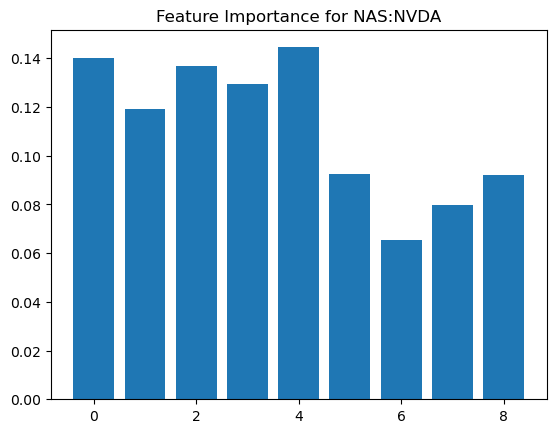



Feature importance for NAS:AAPL:
Feature: 0, Score: 0.12354
Feature: 1, Score: 0.10533
Feature: 2, Score: 0.14046
Feature: 3, Score: 0.14534
Feature: 4, Score: 0.12752
Feature: 5, Score: 0.07550
Feature: 6, Score: 0.07313
Feature: 7, Score: 0.08256
Feature: 8, Score: 0.12662


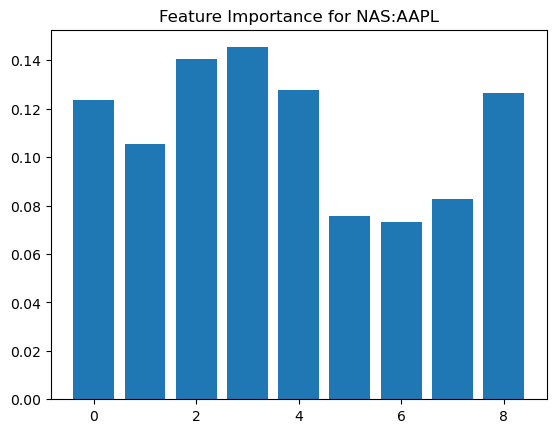



Feature importance for NAS:AMZN:
Feature: 0, Score: 0.12393
Feature: 1, Score: 0.10819
Feature: 2, Score: 0.13134
Feature: 3, Score: 0.12179
Feature: 4, Score: 0.14407
Feature: 5, Score: 0.07732
Feature: 6, Score: 0.08810
Feature: 7, Score: 0.09942
Feature: 8, Score: 0.10583


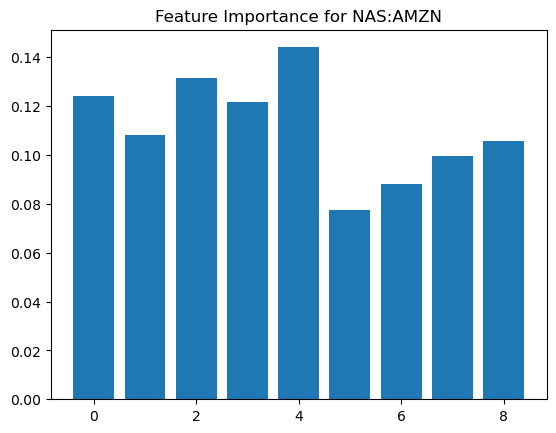



Feature importance for NAS:GOOGL:
Feature: 0, Score: 0.11764
Feature: 1, Score: 0.11295
Feature: 2, Score: 0.12352
Feature: 3, Score: 0.14574
Feature: 4, Score: 0.13918
Feature: 5, Score: 0.07707
Feature: 6, Score: 0.07273
Feature: 7, Score: 0.08467
Feature: 8, Score: 0.12650


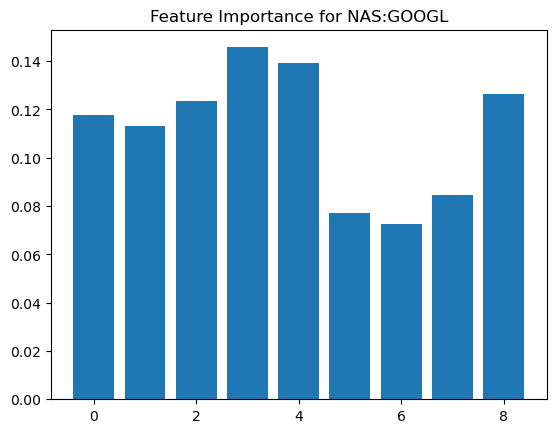



Feature importance for NYS:BAC:
Feature: 0, Score: 0.12747
Feature: 1, Score: 0.14056
Feature: 2, Score: 0.11217
Feature: 3, Score: 0.12924
Feature: 4, Score: 0.13247
Feature: 5, Score: 0.08084
Feature: 6, Score: 0.06676
Feature: 7, Score: 0.06648
Feature: 8, Score: 0.14402


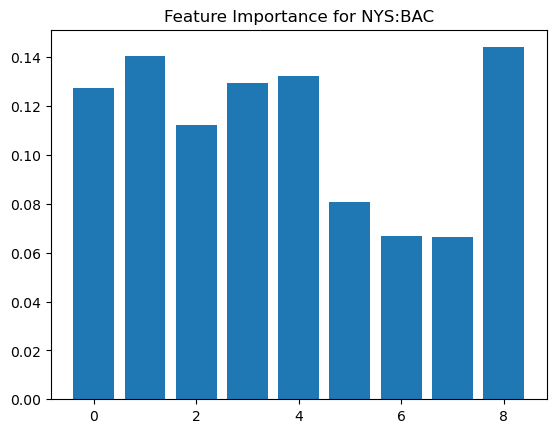

In [11]:
# Showing which features are more important in predicting for the top 5 selected companies:
import matplotlib.pyplot as plt

# Assuming `models` and `selected_assets` are already defined
for asset_name in top_20_liquid_assets.index[:5]:
    print(f"Feature importance for {asset_name}:")

    try:
        importance = models[asset_name].feature_importances_
        
        # Display feature importance
        for i, v in enumerate(importance):
            print('Feature: %0d, Score: %.5f' % (i, v))

        # Plot feature importance
        plt.bar([x for x in range(len(importance))], importance)
        plt.title(f"Feature Importance for {asset_name}")
        plt.show()

    except AttributeError:
        print(f"Model for {asset_name} does not support feature importances.")
    except KeyError:
        print(f"No trained model available for {asset_name}.")

    print("\n")


In [12]:
# Performs prediction and generates output weights for the top 20 selected companies:

selected_assets = top_20_liquid_assets.index
weights = xr.zeros_like(stock_data.sel(field="close"))

for asset_name in selected_assets:
    if asset_name in models:
        model = models[asset_name]
        features_all = my_features
        features_cur = features_all.sel(asset=asset_name).dropna("time", "any")
        if len(features_cur.time) < 1:
            continue
        try:
            weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)
        except KeyboardInterrupt as e:
            raise e
        except Exception as e:
            logging.exception(f"Model prediction failed for asset {asset_name}: {e}")

print(weights)


<xarray.DataArray 'stocks_s&p500' (time: 4954, asset: 516)> Size: 20MB
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.19548071,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.14062587,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.11253226,  0.        , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
  * time     (time) datetime64[ns] 40kB 2005-06-01 2005-06-02 ... 2025-02-06
    field    <U5 20B 'close'
  * asset    (asset) <U9 19kB 'NAS:AAL' 'NAS:AAPL' ... 'NYS:ZBH' 'NYS:ZTS'


In [13]:
def get_sharpe(stock_data, weights):
    """Calculates the Sharpe ratio"""
    rr = qnstats.calc_relative_return(stock_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(stock_data, weights)
sharpe

83.72234591945735

The sharpe ratio using the method above follows from **forward looking**. Predictions for (let us say) 2017 know about the relation between features and targets in 2020. Let us visualize the results:

In [14]:
import qnt.graph as qngraph

statistics = qnstats.calc_stat(stock_data, weights)

display(statistics.to_pandas().tail())

performance = statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())

# check for correlations with existing strategies:
qnstats.print_correlation(weights,stock_data)

field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2025-01-31,3.512478e+23,0.009792,0.176774,0.000000,-0.142928,83.728836,14.801044,-0.090828,20.0,1.166815,1.682722
2025-02-03,3.535435e+23,0.006536,0.176759,0.000000,-0.142928,83.715698,14.797475,0.923506,20.0,1.166822,1.682726
2025-02-04,3.662200e+23,0.035856,0.176829,0.000000,-0.142928,83.792740,14.817003,-0.013729,20.0,1.166854,1.682713
2025-02-05,3.624250e+23,-0.010363,0.176877,-0.010363,-0.142928,83.672685,14.799812,0.480099,20.0,1.166857,1.682732
2025-02-06,3.704236e+23,0.022070,0.176877,0.000000,-0.142928,83.722346,14.808557,0.059074,20.0,1.166850,1.682731


time,2025-02-06
field,
sharpe_ratio,83.722346



Ok. This strategy does not correlate with other strategies.


In [15]:
# Filtrar los pesos para las empresas seleccionadas
filtered_weights = weights.sel(asset=top_20_liquid_assets.index)

# Asegurarse de que las dimensiones de tiempo y activos coincidan
aligned_target, aligned_weights = xr.align(my_targetclass, filtered_weights, join="inner")


Let us now use the Quantiacs **backtester** for avoiding **forward looking**.

The backtester performs some transformations: it trains the model on one slice of data (using only data from the past) and predicts the weights for the following slice on a rolling basis:

In [19]:
def strategy(data, state=None, mfsp=135, limit=0.0205):
    """Implements a trading strategy based on ATR and money flow share.
    
    Args:
        data (xarray.Dataset): The dataset containing market data.
        state: Used in the backtester for stateful strategies.
        mfsp (int): Moving average period for money flow share.
        limit (float): Threshold for ATR-to-close ratio.

    Returns:
        xarray.DataArray: Weights for each asset.
    """
    vol = data.sel(field="vol")  ### Volume values
    liq = data.sel(field="is_liquid")  ### Liquidity values, 1.0 or 0.0 -> True or False
    close = data.sel(field="close")  ### Close prices
    high = data.sel(field="high")  ### Daily high
    low = data.sel(field="low")  ### Daily low

    # Average True Range (ATR) calculation
    atrs = qnta.atr(high=high, low=low, close=close, ma=14)  ### 14-day ATR
    ratio = atrs / close  ### ATR-to-close ratio indicator

    # Strategy condition: Zero weight if ratio exceeds the limit
    weights = xr.where(ratio > limit, 0, 1)

    # Money flow calculations
    money_vol = vol * liq * close  ### Daily money flow per liquid asset
    total_money_vol = money_vol.sum(dim='asset', skipna=True)  ### Total daily money flow of liquid assets
    money_vol_share = money_vol / total_money_vol  ### Daily money flow share per liquid asset

    # Moving average of money flow share
    mvs_mov = qnta.sma(money_vol_share, mfsp)  ### 135-day moving average of money flow share

    return mvs_mov * weights

In [20]:
def train_model(data):
    """Create and train the model working on an asset-by-asset basis."""

    # Asegúrate de que los nombres de los activos coincidan
    selected_assets = [asset for asset in top_20_liquid_assets.index if asset in data.coords["asset"].values]
    data = data.sel(asset=selected_assets)

    asset_name_all = data.coords["asset"].values
    features_all   = get_features(data, selected_assets)
    target_all     = get_target_classes(data, selected_assets)

    models = dict()

    for asset_name in asset_name_all:
        # drop missing values:
        target_cur   = target_all.sel(asset=asset_name).dropna("time", "any")
        features_cur = features_all.sel(asset=asset_name).dropna("time", "any")

        # align features and targets:
        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
            # not enough points for training
            continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except Exception as e:
            logging.exception(f"Model training failed for asset {asset_name}: {e}")

    # Incorporar lógica de estrategia al entrenamiento
    try:
        strategy_weights = strategy(data)
        logging.info("Strategy weights calculated and used as additional feature.")
    except Exception as e:
        logging.exception(f"Strategy weight calculation failed: {e}")

    return models


In [21]:
def predict_weights(models, data, selected_assets):
    """The model predicts if the price is going up or down.
       The prediction is performed for several days in order to speed up the evaluation.
    """

    # Filtrar los activos disponibles
    available_assets = [asset for asset in selected_assets if asset in data.coords["asset"].values]
    data = data.sel(asset=available_assets)

    weights = xr.zeros_like(data.sel(field="close"))

    for asset_name in available_assets:
        if asset_name in models:
            model = models[asset_name]
            features_all = get_features(data, available_assets)
            features_cur = features_all.sel(asset=asset_name).dropna("time", "any")

            if len(features_cur.time) < 1:
                continue

            try:
                # Realizar predicciones con el modelo
                model_predictions = model.predict(features_cur.values)
                weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model_predictions
            except KeyboardInterrupt as e:
                raise e
            except Exception as e:
                logging.exception(f"Model prediction failed for asset {asset_name}: {e}")

    try:
        # Incorporar lógica de estrategia en los pesos
        strategy_weights = strategy(data)
        weights = weights * strategy_weights  # Combinar predicciones del modelo con pesos de la estrategia
        logging.info("Strategy weights applied to model predictions.")
    except Exception as e:
        logging.exception(f"Strategy weight calculation failed: {e}")

    return weights



In [22]:
weights = qnbt.backtest_ml(
    train                         = train_model,
    predict                       = lambda m, d: predict_weights(m, d, top_20_liquid_assets.index),
    train_period                  = 2 * 365,
    retrain_interval              = 10 * 365,
    retrain_interval_after_submit = 1,
    predict_each_day              = False,
    competition_type              = "stocks_nasdaq100",
    lookback_period               = 365,
    start_date                    = "2005-01-01",
    analyze                       = True,
    build_plots                   = True
)


Run the last iteration...


100% (44115 of 44115) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (8930364 of 8930364) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/1 2s
Data loaded 2s


100% (31672 of 31672) |##################| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/1 0s
Data loaded 0s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.
Write output: /root/fractions.nc.gz
State saved.
---
Run First Iteration...


100% (44115 of 44115) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (9037908 of 9037908) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/1 2s
Data loaded 2s
---
Run all iterations...
Load data...


100% (44115 of 44115) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (13049888 of 13049888) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/8 1s


100% (13049888 of 13049888) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 2/8 1s


100% (13049888 of 13049888) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 3/8 2s


100% (13049864 of 13049864) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 4/8 3s


100% (13049796 of 13049796) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 5/8 4s


100% (13049796 of 13049796) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 6/8 5s


100% (13049796 of 13049796) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 7/8 5s


100% (13049864 of 13049864) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 8/8 6s
Data loaded 6s


100% (44115 of 44115) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (12967240 of 12967240) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/7 1s


100% (12967236 of 12967236) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 2/7 1s


100% (12967236 of 12967236) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 3/7 2s


100% (12967212 of 12967212) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 4/7 3s


100% (12967132 of 12967132) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 5/7 3s


100% (12967132 of 12967132) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 6/7 4s


100% (12967212 of 12967212) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 7/7 5s
Data loaded 5s
Backtest...


100% (44115 of 44115) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (13069800 of 13069800) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/7 1s


100% (13069796 of 13069796) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 2/7 2s


100% (13069796 of 13069796) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 3/7 2s


100% (13069772 of 13069772) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 4/7 3s


100% (13069692 of 13069692) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 5/7 4s


100% (13069692 of 13069692) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 6/7 5s


100% (13069772 of 13069772) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 7/7 6s
Data loaded 6s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.
Write output: /root/fractions.nc.gz
State saved.
---
Analyze results...
Check...
Check liquidity...
Ok.
Check missed dates...
Ok.
Check the sharpe ratio...
Period: 2006-01-01 - 2025-02-06
Sharpe Ratio = -1.3104452891015463


ERROR! The Sharpe Ratio is too low. -1.3104452891015463 < 0.7
Improve the strategy and make sure that the in-sample Sharpe Ratio more than 0.7.


---
Align...
Calc global stats...
---
Calc stats per asset...
Build plots...
---
Select the asset (or leave blank to display the overall stats):


interactive(children=(Combobox(value='', description='asset', options=('', 'NAS:AAL', 'NAS:AAPL', 'NAS:ABNB', …

100% (5057 of 5057) |####################| Elapsed Time: 0:00:32 Time:  0:00:32


The Sharpe ratio is obviously smaller as the training process is not looking forward (as it happens by processing data on a global basis), but performed on a rolling basis.

# May I import libraries?

Yes, please refer to the file **init.ipynb** in your home directory. You can for example use:

! conda install -y scikit-learn

# How to load data?

Daily stock data for the **Q18 Nasdaq-100** contest can be loaded using:
```python
data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Cryptocurrency daily data used for the Q16/Q17 contests can be loaded using:
```python
data = qndata.cryptodaily.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Futures data for the Q15 contest can be loaded using:
```python
data= qndata.futures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

BTC Futures data for the Q15 contest can be loaded using:
```python
data= qndata.cryptofutures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

# How to view a list of all tickers?

```python
data.asset.to_pandas().to_list()
```

# How to see which fields are available?

```python
data.field.to_pandas().to_list()
```

# How to load specific tickers?

```python
data = qndata.stocks.load_ndx_data(tail=17 * 365, assets=["NAS:AAPL", "NAS:AMZN"])
```

# How to select specific tickers after loading all data?

```python
def get_data_filter(data, assets):
    filler= data.sel(asset=assets)
    return filler

get_data_filter(data, ["NAS:AAPL", "NAS:AMZN"])
```

# How to get the prices for the previous day?

```python
qnta.shift(data.sel(field="open"), periods=1)
```

or:

```python
data.sel(field="open").shift(time=1)
```

# How to get the Sharpe ratio?

```python
import qnt.stats as qnstats

def get_sharpe(market_data, weights):
    rr = qnstats.calc_relative_return(market_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(data, weights) # weights.sel(time=slice("2006-01-01",None))
```

# How do I get a list of the top 3 assets ranked by Sharpe ratio?

```python
import qnt.stats as qnstats

data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))

def get_best_instruments(data, weights, top_size):
    # compute statistics:
    stats_per_asset = qnstats.calc_stat(data, weights, per_asset=True)
    # calculate ranks of assets by "sharpe_ratio":
    ranks = (-stats_per_asset.sel(field="sharpe_ratio")).rank("asset")
    # select top assets by rank "top_period" days ago:
    top_period = 1
    rank = ranks.isel(time=-top_period)
    top = rank.where(rank <= top_size).dropna("asset").asset

    # select top stats:
    top_stats = stats_per_asset.sel(asset=top.values)

    # print results:
    print("SR tail of the top assets:")
    display(top_stats.sel(field="sharpe_ratio").to_pandas().tail())

    print("avg SR = ", top_stats[-top_period:].sel(field="sharpe_ratio").mean("asset")[-1].item())
    display(top_stats)
    return top_stats.coords["asset"].values

get_best_instruments(data, weights, 3)
```

# How can I check the results for only the top 3 assets ranked by Sharpe ratio?

Select the top assets and then load their data:

```python
best_assets= get_best_instruments(data, weights, 3)

data= qndata.stocks.load_ndx_data(tail = 17*365, assets=best_assets)
```

# How can prices be processed?

Simply import standard libraries, for example **numpy**:

```python
import numpy as np

high= np.log(data.sel(field="high"))
```

# How can you reduce slippage impace when trading?

Just apply some technique to reduce turnover:

```python
def get_lower_slippage(weights, rolling_time=6):
    return weights.rolling({"time": rolling_time}).max()

improved_weights = get_lower_slippage(weights, rolling_time=6)
```

# How to use technical analysis indicators?

For available indicators see the source code of the library: /qnt/ta

## ATR

```python
def get_atr(data, days=14):
    high = data.sel(field="high") * 1.0
    low  = data.sel(field="low") * 1.0
    close= data.sel(field="close") * 1.0

    return qnta.atr(high, low, close, days)

atr= get_atr(data, days=14)
```

## EMA

```python
prices= data.sel(field="high")
prices_ema= qnta.ema(prices, 15)
```

## TRIX

```python
prices= data.sel(field="high")
prices_trix= qnta.trix(prices, 15)
```

## ADL and EMA

```python
adl= qnta.ad_line(data.sel(field="close")) * 1.0
adl_ema= qnta.ema(adl, 18)
```

# How can you check the quality of your strategy?

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

or

```python
stat= qnstats.calc_stat(data, weights)
display(stat.to_pandas().tail())
```

or

```python
import qnt.graph   as qngraph
statistics= qnstats.calc_stat(data, weights)
display(statistics.to_pandas().tail())

performance= statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())
qnstats.print_correlation(weights, data)

```

# An example using pandas

One can work with pandas DataFrames at intermediate steps and at the end convert them to xarray data structures:

```python
def get_price_pct_change(prices):
    prices_pandas = prices.to_pandas()
    assets = data.coords["asset"].values
    for asset in assets:
        prices_pandas[asset] = prices_pandas[asset].pct_change()
    return prices_pandas

prices = data.sel(field="close") * 1.0
prices_pct_change = get_price_pct_change(prices).unstack().to_xarray()
```

# How to submit a strategy to the competition?

Check that weights are fine:

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

If everything is ok, write the weights to file:

```python
qnout.write(weights)
```

In your **personal account**:

* **choose** a strategy;
* click on the **Submit** button;
* select the type of competition.

At the beginning you will find the strategy under the **Checking** area:

* **Sent strategies** > **Checking**.

If technical checks are successful, the strategy will go under the **Candidates** area:

* **Sent strategies** > **Candidates**.

Otherwise it will be **Filtered**:

* **Sent strategies** > **Filtered**

and you should inspect error and warning messages.

Note that a strategy under the **Candidates** area should have a Sharpe ratio larger than 1 for being eligible for a prize. Please check warning messages in your **Candidates** area!